In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import quant
import json
from matplotlib import pyplot as plt
import numpy as np

## Benchmark Kernel
Tests the speed of the Triton, CUDA, and FP16 kernels on 4096x4096, 4096x11008, 11008x4096, and 4096x12288 matrices.

4096->4096


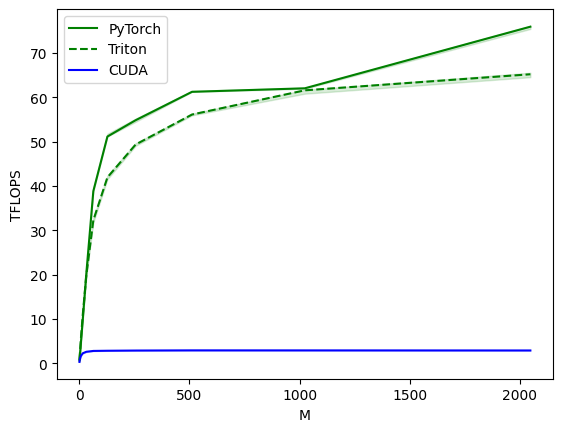

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.668735   0.780190  0.348596
1      2.0   1.260308   1.489455  0.675629
2      4.0   2.520615   2.912711  1.139756
3      8.0   4.946113   5.825422  1.724632
4     16.0   9.892226  10.922666  2.279513
5     32.0  20.164923  19.784453  2.621440
6     64.0  38.836148  32.263877  2.814969
7    128.0  51.150050  41.943041  2.855210
8    256.0  54.827503  49.344753  2.901629
9    512.0  61.230717  56.111089  2.941049
10  1024.0  62.022981  61.567763  2.935389
11  2048.0  75.915006  65.185878  2.918157


4096->11008


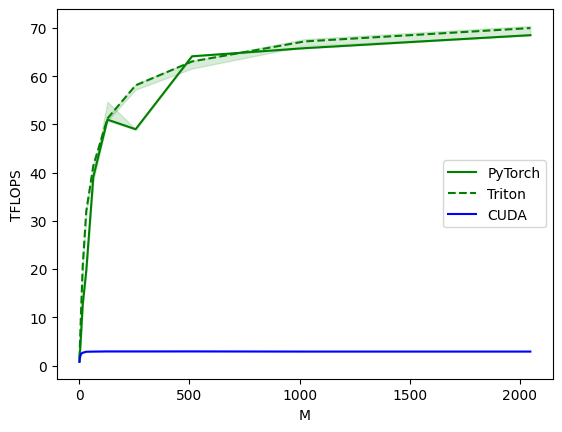

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.759172   1.420387  0.815407
1      2.0   1.586739   2.752000  1.334303
2      4.0   3.202327   5.504000  1.834667
3      8.0   6.346955  10.838646  2.404478
4     16.0  12.693910  20.720941  2.663561
5     32.0  19.706630  32.023272  2.858061
6     64.0  39.139554  41.441882  2.891789
7    128.0  51.005395  51.237236  2.927842
8    256.0  49.009529  58.104085  2.925183
9    512.0  64.137650  63.061216  2.933557
10  1024.0  65.823021  67.221422  2.898388
11  2048.0  68.523963  69.986444  2.898574


11008->4096


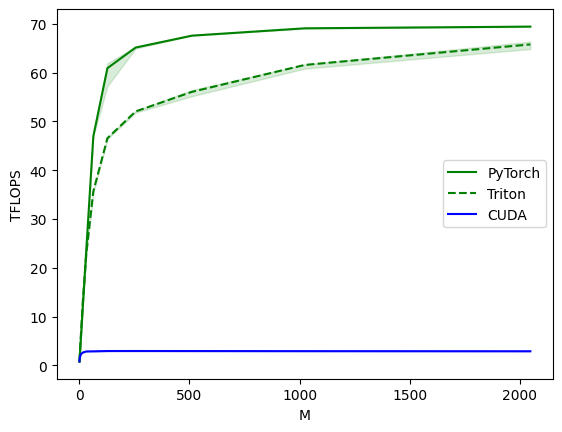

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.721836   0.898612  0.830792
1      2.0   1.505367   1.743842  1.314388
2      4.0   3.010735   3.453490  1.844272
3      8.0   6.021470   6.584224  2.332821
4     16.0  11.940881  12.926826  2.636153
5     32.0  23.681076  22.910958  2.860962
6     64.0  46.967468  35.671495  2.888824
7    128.0  60.930769  46.579307  2.949291
8    256.0  65.157182  52.065551  2.954316
9    512.0  67.599351  56.080556  2.944092
10  1024.0  69.101558  61.596679  2.925752
11  2048.0  69.447467  65.799007  2.904549


4096->12288


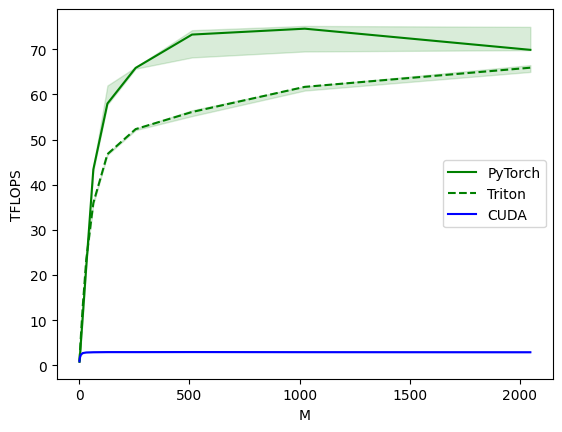

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.762047   0.910222  0.893673
1      2.0   1.374881   1.787345  1.394383
2      4.0   2.749762   3.510857  1.908816
3      8.0   5.499525   6.898526  2.375928
4     16.0  10.922666  13.107200  2.716518
5     32.0  21.998098  23.475582  2.851975
6     64.0  43.389352  35.951178  2.905984
7    128.0  57.985771  46.776623  2.935817
8    256.0  65.879121  52.319801  2.934448
9    512.0  73.262953  56.111089  2.947508
10  1024.0  74.565403  61.680942  2.924898
11  2048.0  69.880801  65.922264  2.905649


In [2]:
def benchmarker(M, N, K, provider):
	layer = nn.Linear(K, N)
	vec = torch.randn(M, K, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cuda_layer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, quantizer.scale, quantizer.zero)

	# Convert layer to 16-bit
	layer = layer.half()

	# Convert cuda_layer to Triton
	state_dict = cuda_layer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	triton_layer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	triton_layer.load_state_dict(state_dict)

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 4096, provider)

print("4096->4096")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 11008, 4096, provider)

print("4096->11008")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 11008, provider)

print("11008->4096")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 12288, provider)

print("4096->12288")
benchmark.run(show_plots=True, print_data=True)

## Benchmark In-Situ
Benchmark Triton and CUDA kernels in the model itself. This is useful because sometimes the Triton kernel is faster in isolation, but performs worse within the context of the model.

In [3]:
# Load the models
cuda_model = original_quant.load_cuda_quant('../weights/HF/llama-7b', '../GPTQ-for-LLaMa/llama7b-4bit-128g-2.pt', 4, -1)
cuda_model.eval()
cuda_model = cuda_model.to('cuda')

model = quant.load_quant('../weights/llama-7b-4bit')
model.eval()
model = model.to('cuda')

Loading model ...
Done.
Loading model ...
Found 4 unique KN values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]

Done.


Lower is better


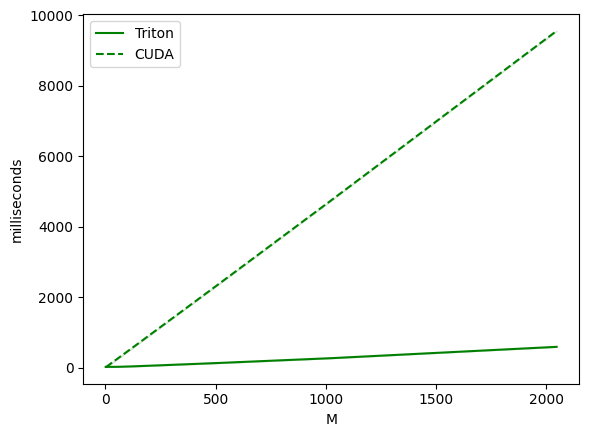

matmul:
         M      Triton         CUDA
0      1.0   20.897282    22.779903
1      2.0   21.496832    23.897087
2      4.0   22.162432    24.341503
3      8.0   22.749695    41.632256
4     16.0   22.639616    78.107651
5     32.0   22.138880   152.176636
6     64.0   24.495104   298.062836
7    128.0   37.749760   590.635498
8    256.0   68.293633  1181.648438
9    512.0  132.199417  2363.913818
10  1024.0  268.753906  4747.293945
11  2048.0  590.776855  9561.542969




In [5]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'torch':
		raise NotImplementedError
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['triton', 'cuda'],
		line_names=['Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Visualize `benchmark_generate.py` Results
Run `benchmark_generate.py` and save the results to `results-triton.jsonl` and `results-cuda.jsonl`.  Then run this cell to visualize the results.

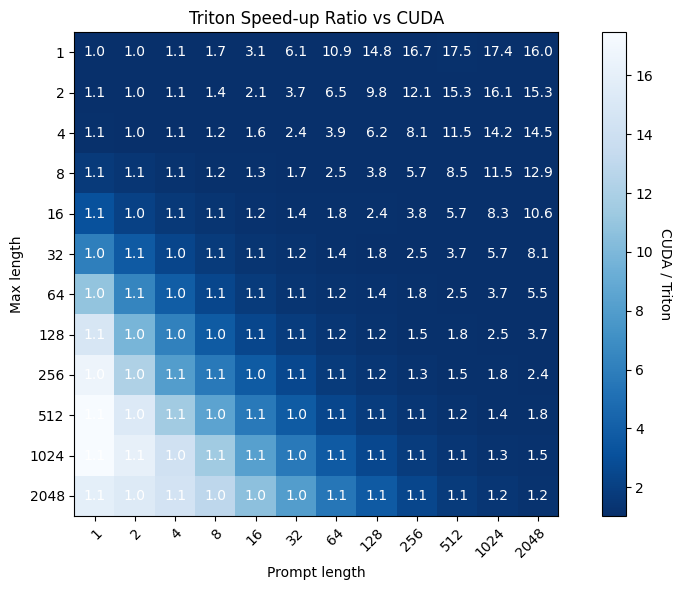

Minimum speed-up: 102.5%
Maximum speed-up: 1746.5%


In [7]:
def read_results(filename):
	with open(filename, 'r') as f:
		results = [json.loads(line) for line in f]
		results = sorted(results, key=lambda x: (x['prompt_length'], x['max_length']))
	return results


# Read the results
triton_results = read_results('results-triton.jsonl')
cuda_results = read_results('results-cuda.jsonl')

# Results as a 2D heatmap
x = sorted(list(set(a['prompt_length'] for a in triton_results)))
y = sorted(list(set(a['max_length'] for a in triton_results)))

z1 = lambda x, y: next(a for a in triton_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z2 = lambda x, y: next(a for a in cuda_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z = lambda x, y: z2(x, y) / z1(x, y)

# Draw a heatmap with numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow([[z(i, j) for j in y] for i in x], cmap='Blues_r')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('CUDA / Triton', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(x)):
	for j in range(len(y)):
		text = ax.text(i, j, f'{z(x[i], y[j]):.1f}', ha="center", va="center", color="w")

# Label axes
ax.set_xlabel('Prompt length')
ax.set_ylabel('Max length')

ax.set_title("Triton Speed-up Ratio vs CUDA")
f.tight_layout()
plt.show()

# Print some stats
print(f"Minimum speed-up: {(min(z(i, j) for i in x for j in y) * 100):.1f}%")
print(f"Maximum speed-up: {(max(z(i, j) for i in x for j in y) * 100):.1f}%")

## Config Usage
Print out the kernel configurations used by the above code.  Useful for determining which configurations are useful on a given GPU.

In [8]:
from quant import matmul4_kernel

def config_to_str(config):
	kwargs = ', '.join(f"'{k}': {v}" for k,v in config.kwargs.items())
	return f"{{{kwargs}}}, num_stages={config.num_stages}, num_warps={config.num_warps}"

print("Used kernel configs:")
configs = set(config_to_str(x) for x in matmul4_kernel.cache.values())
for config in configs:
	print(config)

print()
print("Kernel configs sorted by size:")
for k in sorted(matmul4_kernel.cache.keys()):
	print(f'{k}: {config_to_str(matmul4_kernel.cache[k])}')

Used kernel configs:
{'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4
{'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8
{'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=8
{'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8
{'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4
{'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4
{'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4
{'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4
{'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4
{'BLOCK_SI